<center><font size="4"><span style="color:blue">Demonstration 2: benchmark about anomaly detection</span></font></center>

This is a demonstration of a specific challenge (benchmark) that practitioners and researchers can use together with the 3W dataset, and that is defined in the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

**_Disclamer_**

_This notebook presents a demonstration. As we have not experienced all the possibilities, for example in terms of approaches, methods, parameter values, and metrics, we do not argue that the results presented here are optimal. However, these results can be used as baseline for other works._

# 1. Choices

The more relevant choices of the method implemented for this demonstration are:

1. Only real instances with any type of undesirable event that have normal period are used. The types of events that do not have normal period are not appropriate for this demonstration. Only instances with enough normal period are used. An initial part of each normal period is used in the training;
1. The considered metrics are calculated globally by counting the total true positives, false negatives and false positives. Samples from transient and in-regime periods are grouped as abnormal;
1. The specialists consider that the normality suffers with concept drift. As we don't need to learn the concept drift itself, this method supposes that a dedicated model for each well is trained from time to time;
1. Only classifiers (six in total) implemented in the scikit-learn package are used. As optimization of metrics is not a focus of this work, the parameters of the classifiers are not optimized;
1. A specific sampling strategy with sliding window is used for each type of period. In normal periods, the first observatins are used for training and the last ones are used for testing. In transient periods, it is sought to use observations throughout the transient as a whole for testing (only). In in-regime periods, the first observations are privileged for testing (only);
1. Before each round of training and testing:
    1. The used samples (not instances) are appropriately normalized with z-score;
    1. The variables of samples (not instances) used for training that have a number of NaNs above a threshold or that have a standard deviation below another threshold are discarded.
1. For the sake of execution time, it is used a subset of the minimal set of features of the tsfresh package. Other features can improve the classifiers performances;
1. All required random_state are assigned to a constant for results to be reproducible.

# 2. Imports and Configurations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import warnings
import sys
sys.path.append('stac')
import nonparametric_tests as stac
from math import ceil
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support

In [2]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [4]:
data_path = Path('..', 'data')
gamma = 'scale'
nu = 0.5
random_state = 1
n_jobs = None
clfs = {'One Class SVM - RBF':     OneClassSVM(kernel='rbf', gamma=gamma, nu=nu),
        'One Class SVM - SIGMOID': OneClassSVM(kernel='sigmoid', gamma=gamma, nu=nu),
        'One Class SVM - POLY':    OneClassSVM(kernel='poly', gamma=gamma, nu=nu),
        'One Class SVM - LINEAR':  OneClassSVM(kernel='linear', gamma=gamma, nu=nu),
        'Isolation Forest':        IsolationForest(n_jobs=n_jobs, behaviour='new',
                                                   contamination=0, random_state=random_state),
        'Dummy':                   DummyClassifier(strategy='constant', constant=1)
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
abnormal_classes_codes = [1, 2, 5, 6, 7, 8]
sample_size = 3*60              # In observations = seconds
min_normal_period_size = 20*60  # In observations = seconds
split_range = 0.6               # Train size/test size
max_samples_per_period = 15     # Limitation for safety
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature
max_nan_percent = 0.1           # For selection of useful variables
std_vars_min = 0.01             # For selection of useful variables
disable_progressbar = True      # For less output

In [5]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [6]:
def load_instance(instance_path):
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), 'invalid columns in the file {}: {}'\
            .format(str(instance_path), str(df.columns.tolist()))
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [7]:
def extract_samples(df, class_code):
    # Gets the observations labels and their unequivocal set
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))       
    
    # Discards the observations labels and replaces all nan with 0 
    # (tsfresh's requirement)
    df_vars = df.drop('class', axis=1).fillna(0)  
    
    # Initializes objects that will be return
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []
            
    # Find out max numbers of samples from normal, transient and in regime periods
    #
    # Gets indexes (first and last) without overlap with other periods
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Defines the initial numbers of samples for normal period
    max_samples_normal = l_idx-f_idx+1-sample_size
    if (max_samples_normal) > 0:      
        num_normal_samples = min(max_samples_per_period, max_samples_normal)
        num_train_samples = int(split_range*num_normal_samples)
        num_test_samples = num_normal_samples - num_train_samples    
    else:
        num_train_samples = 0
        num_test_samples = 0
    
    # Defines the max number of samples for transient period    
    transient_code = class_code + 100    
    if transient_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
        max_transient_samples = l_idx-f_idx+1-sample_size
    else:
        max_transient_samples = 0            

    # Defines the max number of samples for in regime period
    if class_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # or end of this period
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
        max_in_regime_samples = l_idx-f_idx+1-sample_size
    else:
        max_in_regime_samples = 0   
        
    # Find out proper numbers of samples from normal, transient and in regime periods
    #
    num_transient_samples = ceil(num_test_samples/2)
    num_in_regime_samples = num_test_samples - num_transient_samples
    if (max_transient_samples >= num_transient_samples) and \
       (max_in_regime_samples < num_in_regime_samples):
        num_in_regime_samples = max_in_regime_samples        
        num_transient_samples = min(num_test_samples-num_in_regime_samples, max_transient_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples >= num_in_regime_samples):
        num_transient_samples = max_transient_samples        
        num_in_regime_samples = min(num_test_samples-num_transient_samples, max_in_regime_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples < num_in_regime_samples):
        num_transient_samples = max_transient_samples
        num_in_regime_samples = max_in_regime_samples
        num_test_samples = num_transient_samples+num_in_regime_samples
    #print('num_train_samples: {}'.format(num_train_samples))
    #print('num_test_samples: {}'.format(num_test_samples))        
    #print('num_transient_samples: {}'.format(num_transient_samples))        
    #print('num_in_regime_samples: {}'.format(num_in_regime_samples))
    
    # Extracts samples from the normal period for training and for testing
    #
    # Gets indexes (first and last) without overlap with other periods
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)
    
    # Defines the proper step and extracts samples
    if (num_normal_samples) > 0:  
        if num_normal_samples == max_samples_normal:
            step_max = 1 
        else:
            step_max = (max_samples_normal-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Extracts samples for training
        sample_id = 0
        for idx in range(num_train_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_train = df_samples_train.append(df_sample)
            y_train.append(normal_class_code)
            sample_id += 1
    
        # Extracts samples for testing
        sample_id = 0
        for idx in range(num_train_samples, num_train_samples+num_test_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(normal_class_code)
            sample_id += 1

    # Extracts samples from the transient period (if it exists) for testing
    #  
    if (num_transient_samples) > 0:    
        # Defines the proper step and extracts samples
        if num_transient_samples == max_transient_samples:
            step_max = 1 
        else:
            step_max = (max_transient_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
        
        # Gets indexes (first and last) with possible overlap at the beginning of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code) 

        # Extracts samples
        for idx in range(num_transient_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(transient_code)
            sample_id += 1
            
    # Extracts samples from the in regime period (if it exists) for testing 
    #
    if (num_in_regime_samples) > 0:     
        # Defines the proper step and extracts samples
        if num_in_regime_samples == max_in_regime_samples:
            step_max = 1 
        else:
            step_max = (max_in_regime_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Gets indexes (first and last) with possible overlap at the beginning or end of this period
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1

        # Extracts samples
        for idx in range(num_in_regime_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(class_code)
            sample_id += 1

    return df_samples_train, y_train, df_samples_test, y_test              

In [8]:
def train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs):
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)    
    for clf_name, clf in clfs.items():
        try:
            # Train
            t0 = time()
            if clf_name!='Dummy': 
                clf.fit(X_train)
            else:
                clf.fit(X_train, np.array([1]*len(y_train))) # y_train must have at least one normal sample
            t_train = time() - t0
                
            # Test
            t0 = time()
            y_pred = clf.predict(X_test)
            t_test = time() - t0
            
            # Plots actual and predicted labels
            fig = plt.figure(figsize=(12,1))
            ax = fig.add_subplot(111)
            plt.plot(-(y_pred), marker=11, color='orange', linestyle='') # Inverted order (more natural)
            plt.plot(-(y_test), marker=10, color='green', linestyle='')  # Inverted order (more natural)
            ax.grid(False)
            ax.set_yticks([-1, 1])
            ax.set_yticklabels(['Normal', 'Abnormal'])
            ax.set_title(clf_name)            
            ax.set_xlabel('Sample')
            ax.legend(['Predicted labels', 'Actual labels'])
            plt.show()

            # Calculates the considered scores
            ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
            p, r, f1, _ = ret
            scores = scores.append({'CLASSIFIER': clf_name, 
                                    'PRECISION': p,
                                    'RECALL': r,
                                    'F1': f1,
                                    'TRAINING[s]': t_train, 
                                    'TESTING[s]': t_test}, ignore_index=True)

        except:
            scores = scores.append({'CLASSIFIER': clf_name, 
                                    'PRECISION': np.nan,
                                    'RECALL': np.nan,
                                    'F1': np.nan,
                                    'TRAINING[s]': np.nan, 
                                    'TESTING[s]': np.nan}, ignore_index=True)
        
    return scores

In [9]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

instance 1: ../data/1/WELL-00001_20140124213136.csv
	skipped because normal_period_size is insufficient for training (959)
instance 2: ../data/1/WELL-00002_20140126200050.csv
	skipped because normal_period_size is insufficient for training (1138)
instance 3: ../data/1/WELL-00006_20170801063614.csv


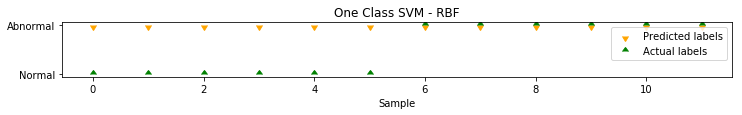

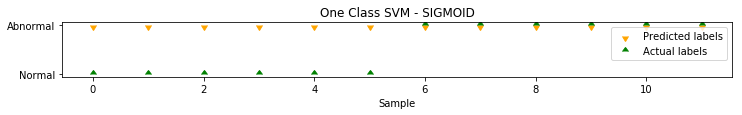

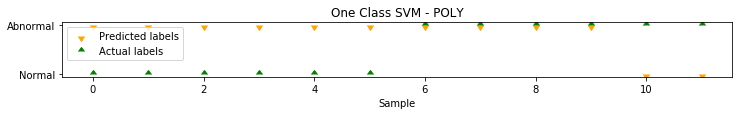

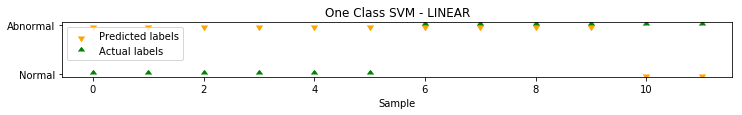

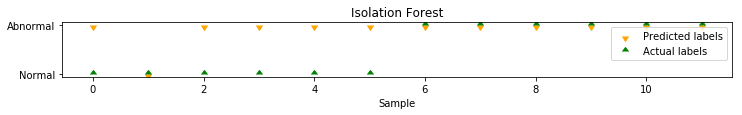

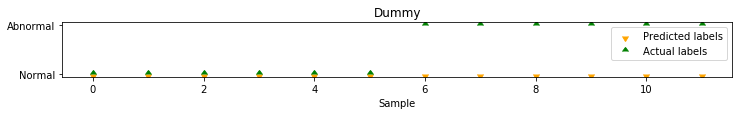

instance 4: ../data/1/WELL-00006_20170802123000.csv


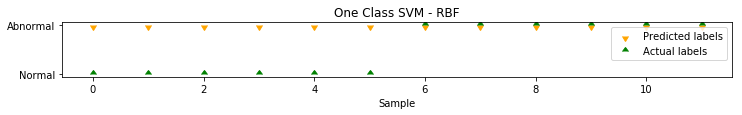

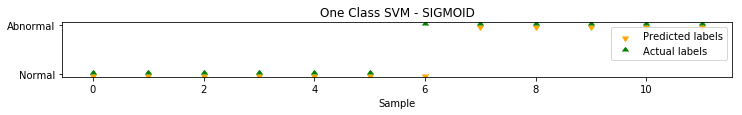

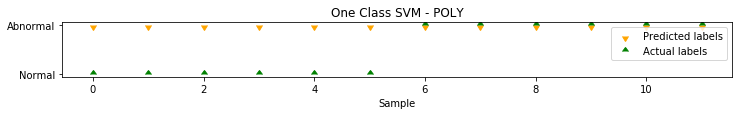

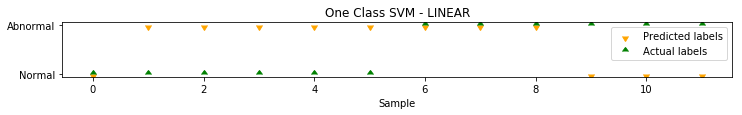

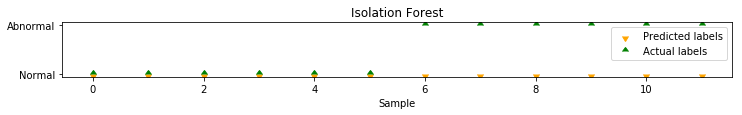

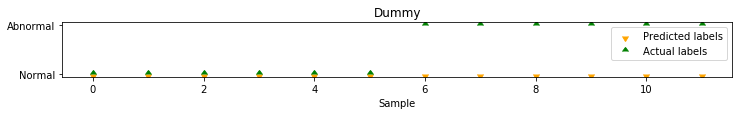

instance 5: ../data/1/WELL-00006_20180618060245.csv


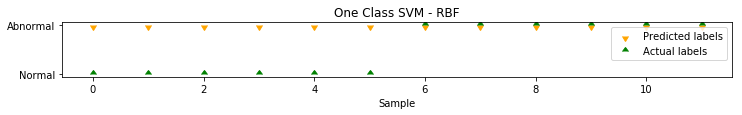

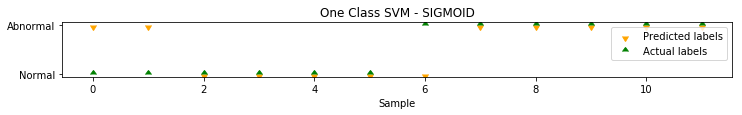

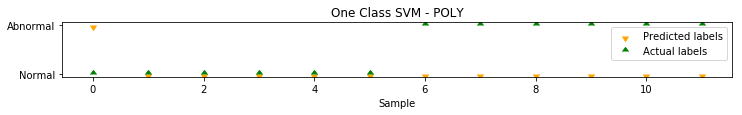

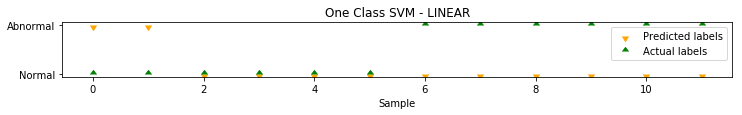

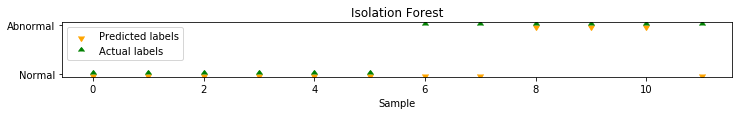

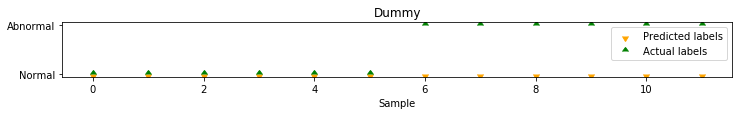

instance 6: ../data/2/WELL-00002_20131104014101.csv


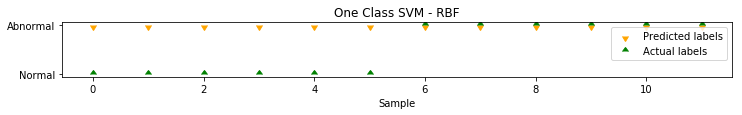

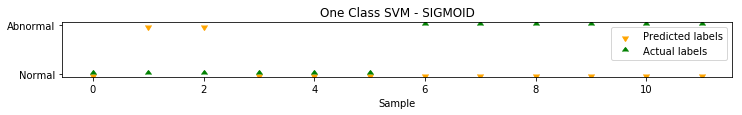

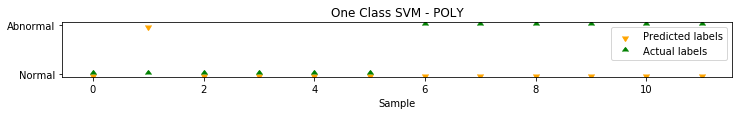

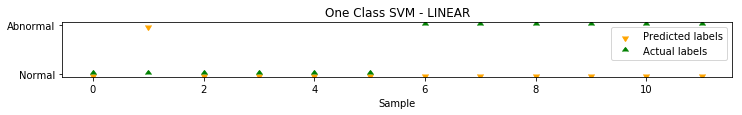

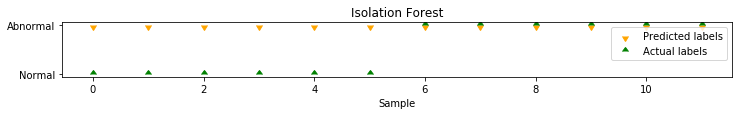

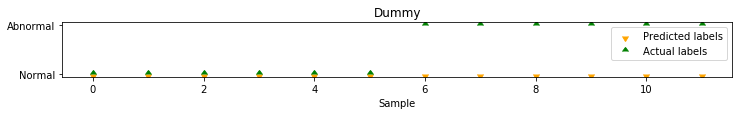

instance 7: ../data/2/WELL-00003_20141122214325.csv


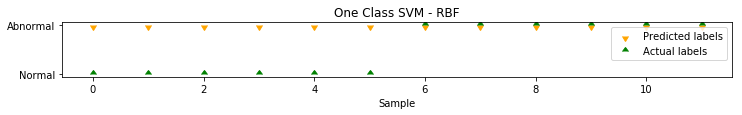

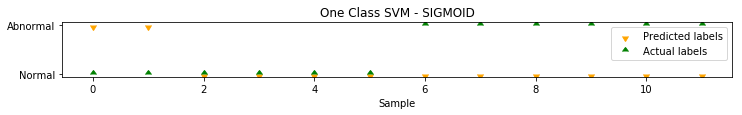

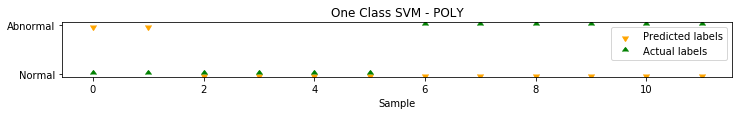

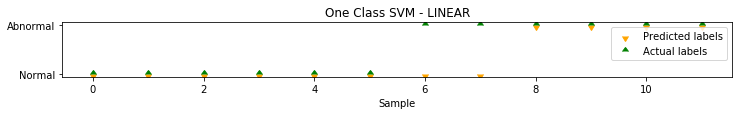

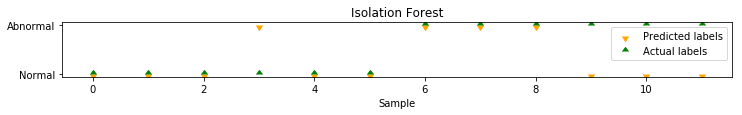

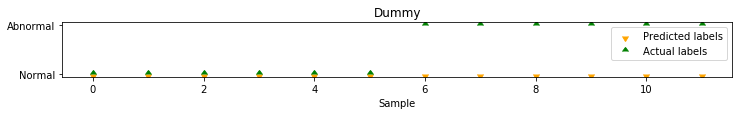

instance 8: ../data/2/WELL-00003_20170728150240.csv


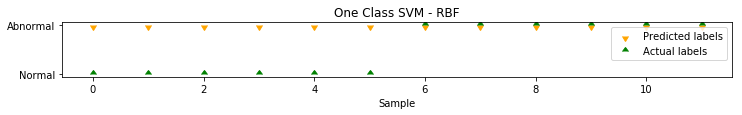

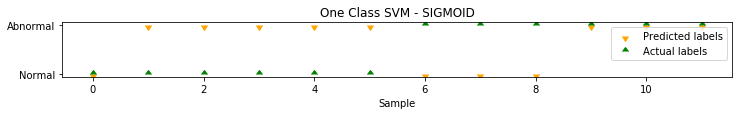

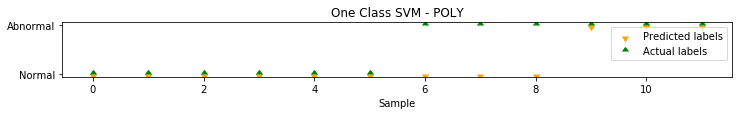

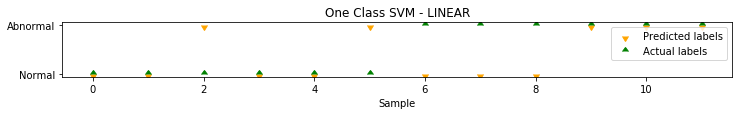

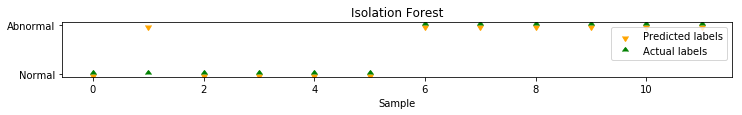

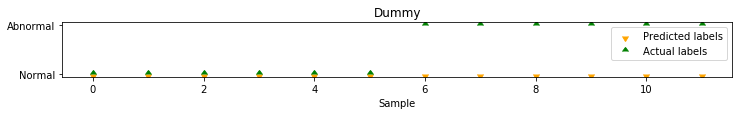

instance 9: ../data/2/WELL-00003_20180206182917.csv
	skipped because normal_period_size is insufficient for training (586)
instance 10: ../data/2/WELL-00009_20170313160804.csv


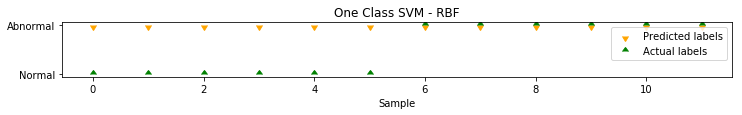

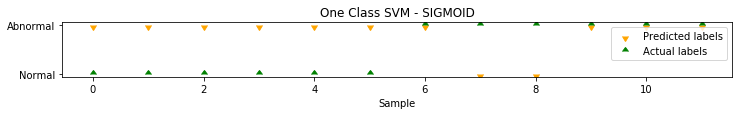

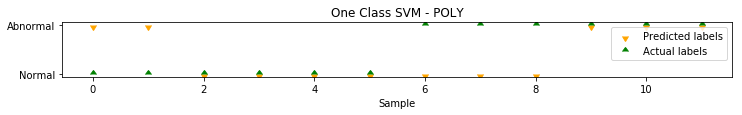

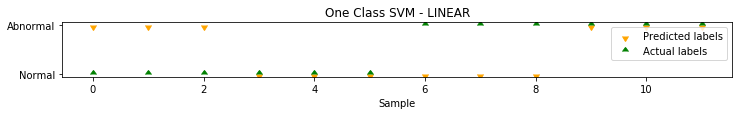

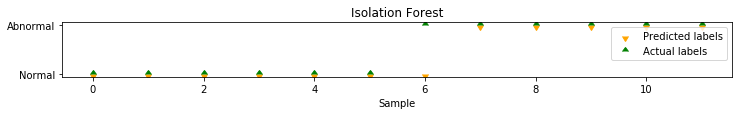

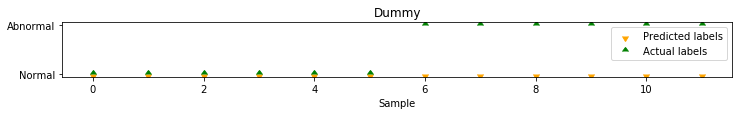

instance 11: ../data/2/WELL-00010_20171218200131.csv


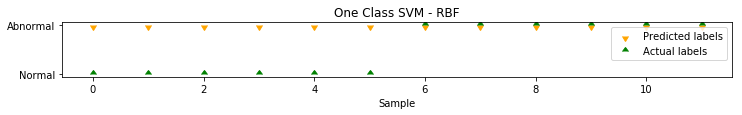

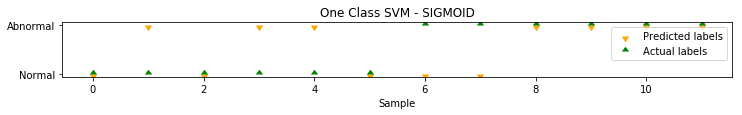

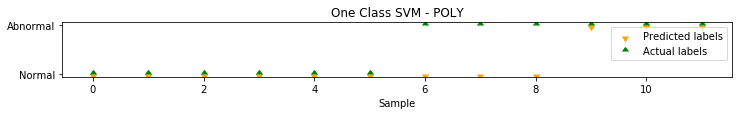

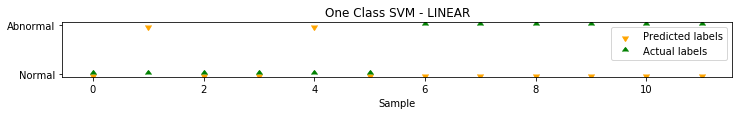

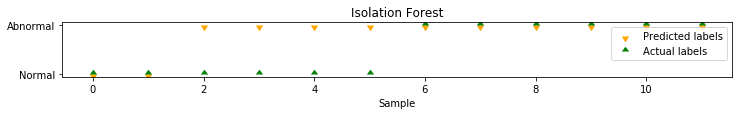

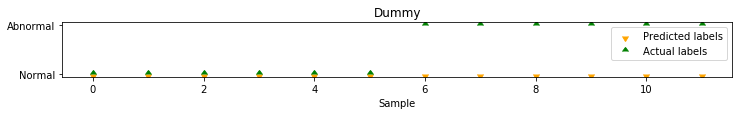

instance 12: ../data/2/WELL-00011_20140515110134.csv


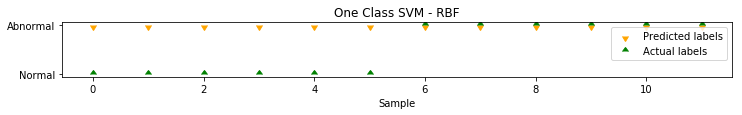

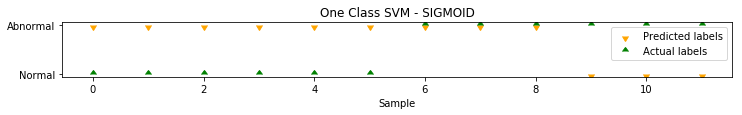

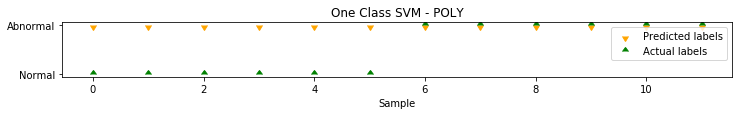

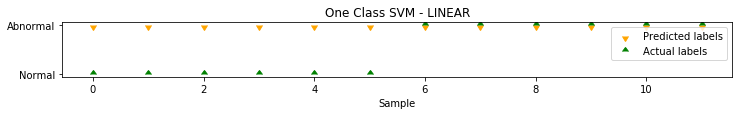

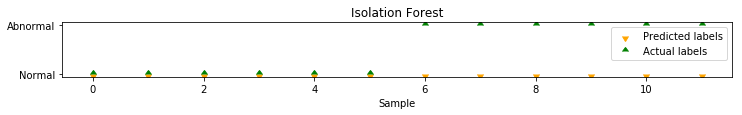

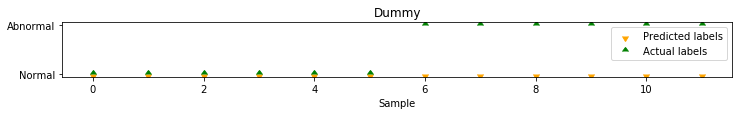

instance 13: ../data/2/WELL-00011_20140530100015.csv
	skipped because normal_period_size is insufficient for training (482)
instance 14: ../data/2/WELL-00011_20140606230115.csv


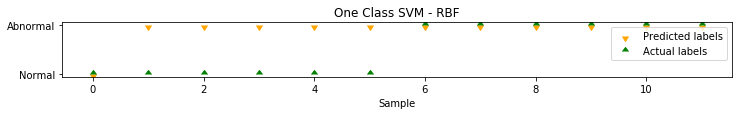

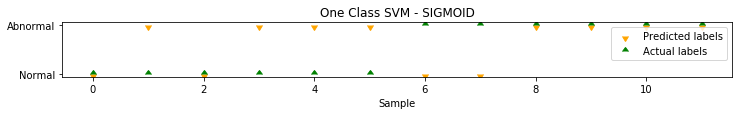

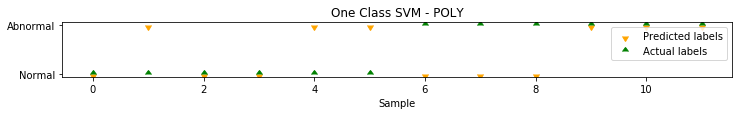

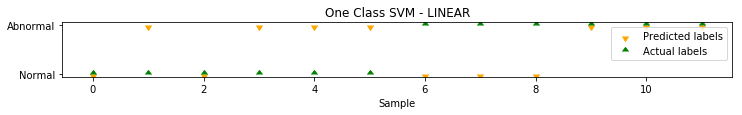

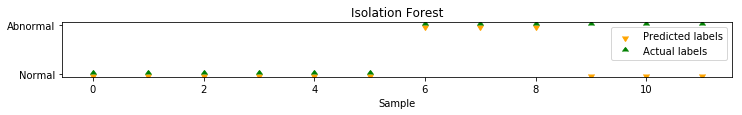

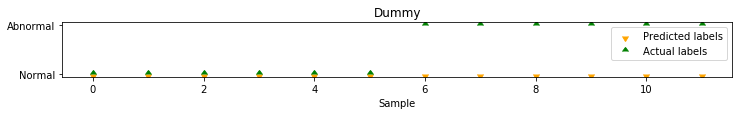

instance 15: ../data/2/WELL-00011_20140720120102.csv


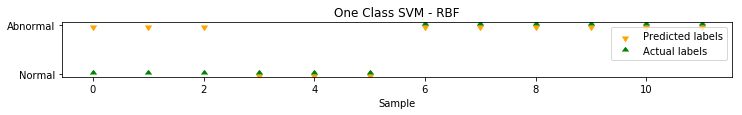

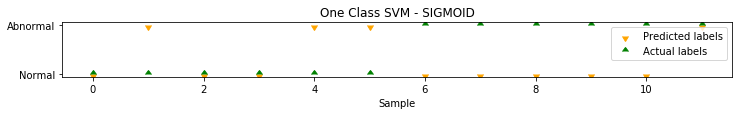

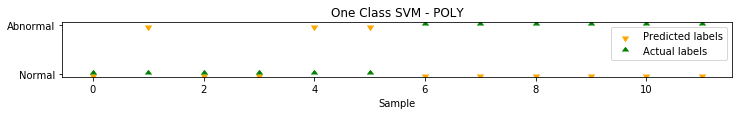

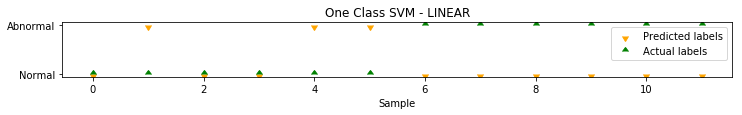

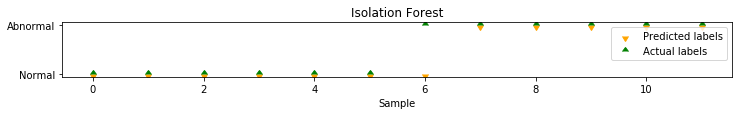

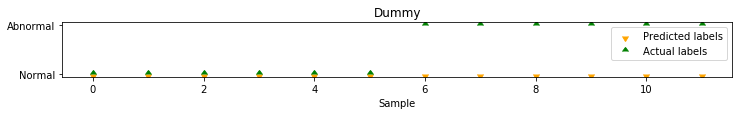

instance 16: ../data/2/WELL-00011_20140726180015.csv
	skipped because normal_period_size is insufficient for training (900)
instance 17: ../data/2/WELL-00011_20140824000118.csv


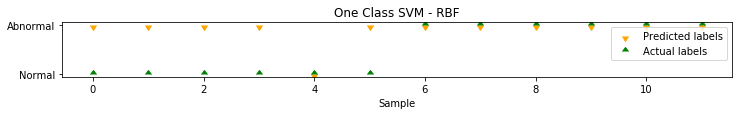

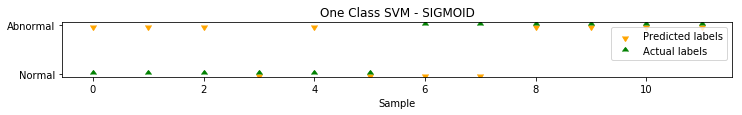

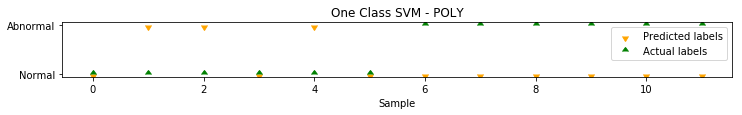

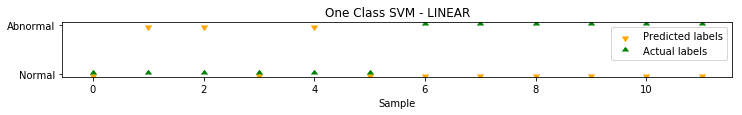

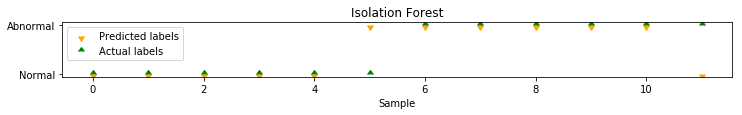

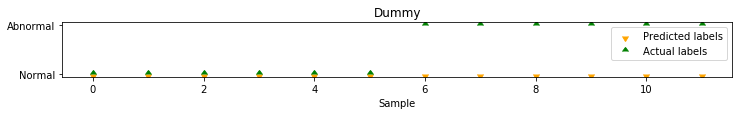

instance 18: ../data/2/WELL-00011_20140916060300.csv


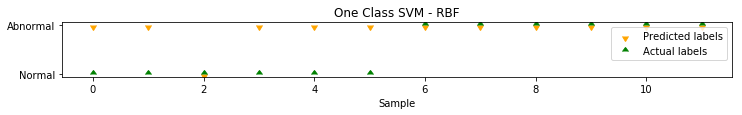

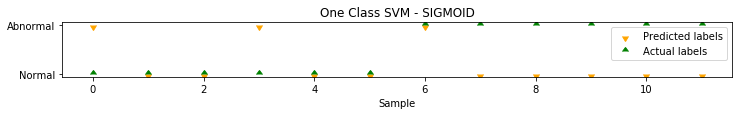

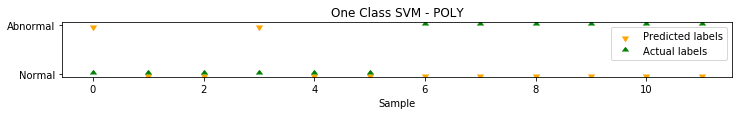

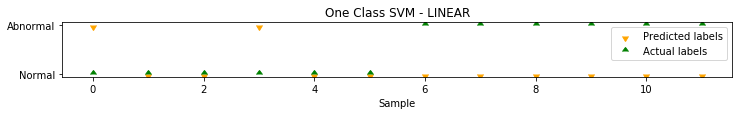

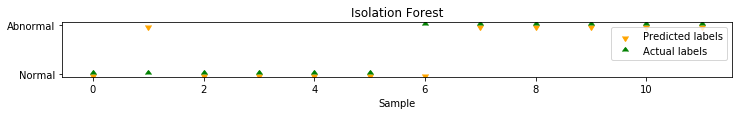

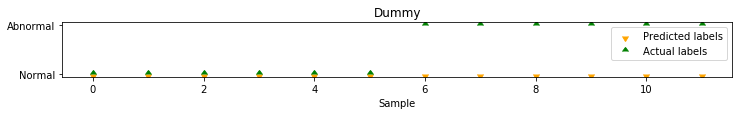

instance 19: ../data/2/WELL-00011_20140921200031.csv
	skipped because normal_period_size is insufficient for training (695)
instance 20: ../data/2/WELL-00011_20140928100056.csv


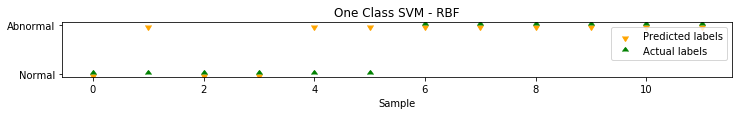

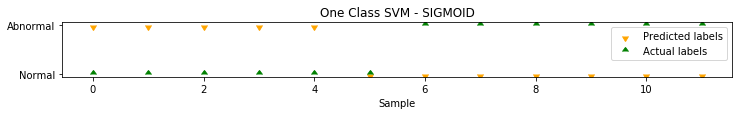

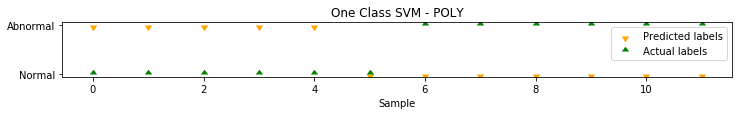

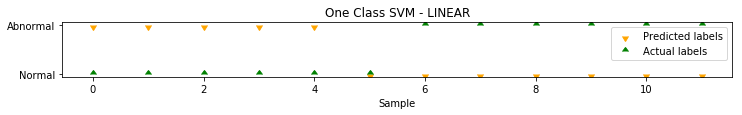

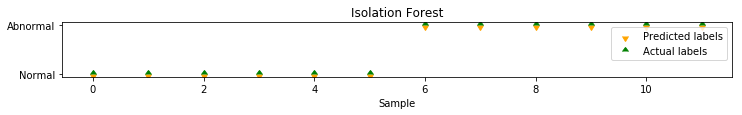

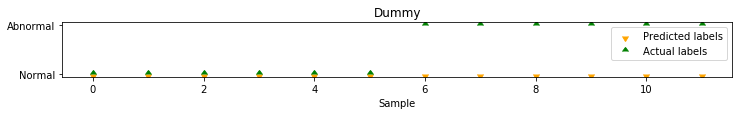

instance 21: ../data/2/WELL-00011_20140929170028.csv
	skipped because normal_period_size is insufficient for training (975)
instance 22: ../data/2/WELL-00011_20140929220121.csv


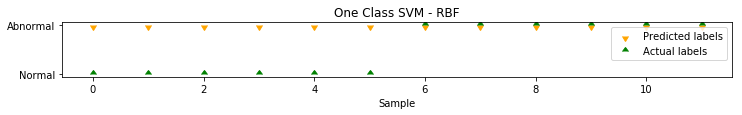

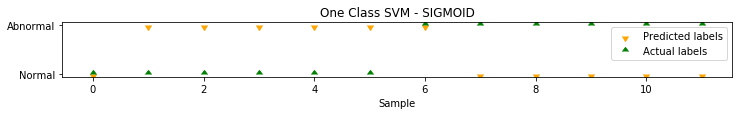

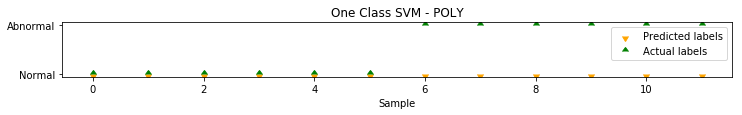

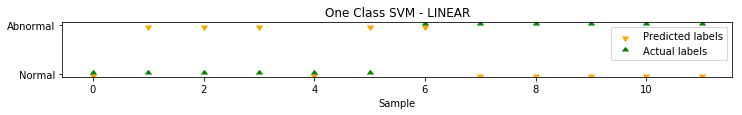

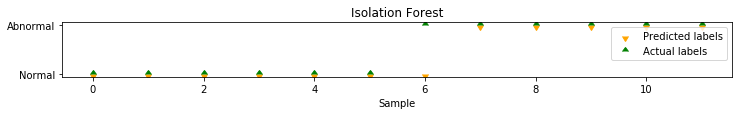

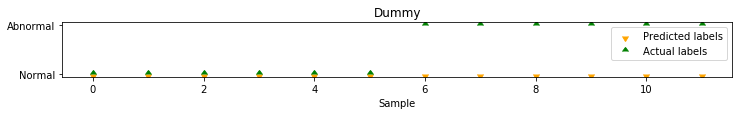

instance 23: ../data/2/WELL-00011_20141005170056.csv


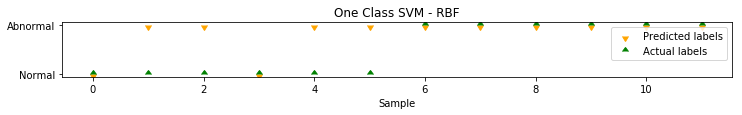

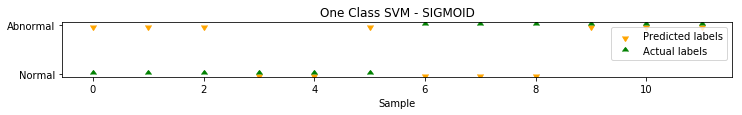

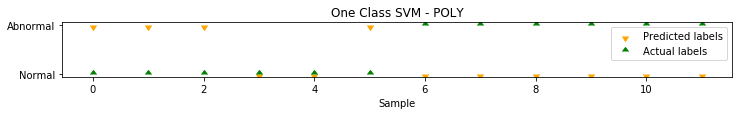

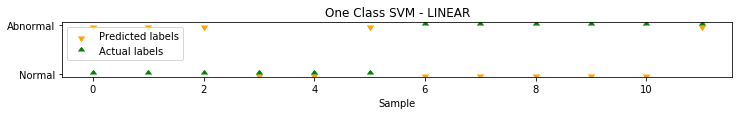

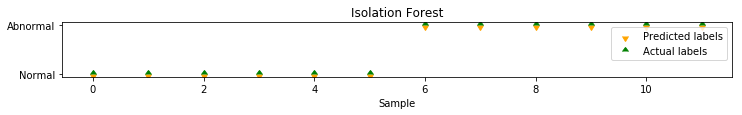

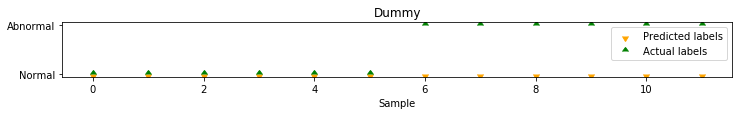

instance 24: ../data/2/WELL-00011_20141006160121.csv


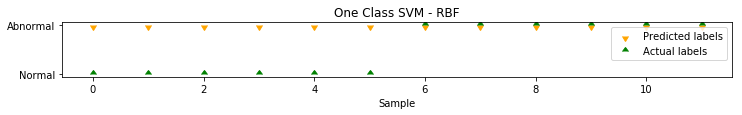

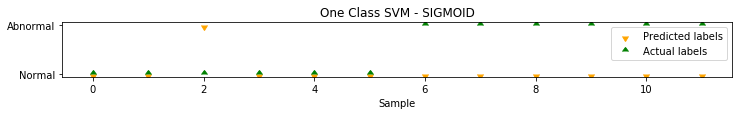

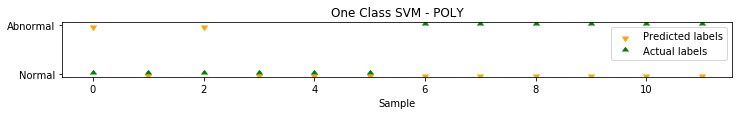

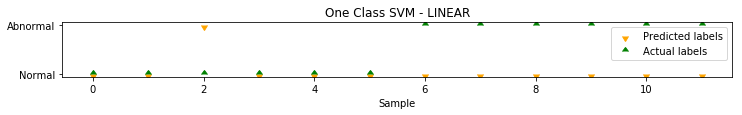

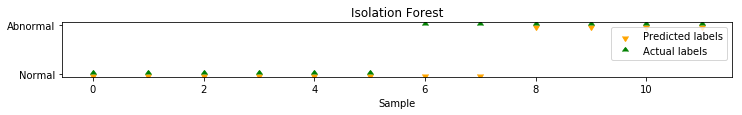

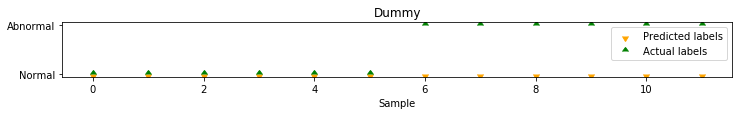

instance 25: ../data/2/WELL-00012_20170320033022.csv
	skipped because normal_period_size is insufficient for training (773)
instance 26: ../data/2/WELL-00012_20170320143144.csv


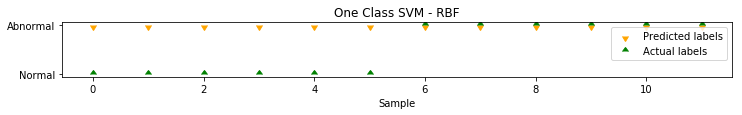

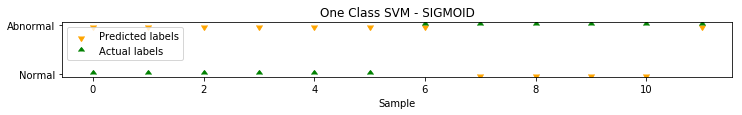

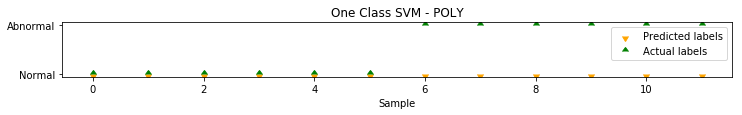

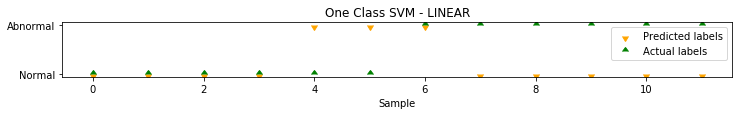

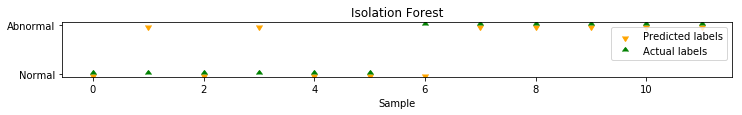

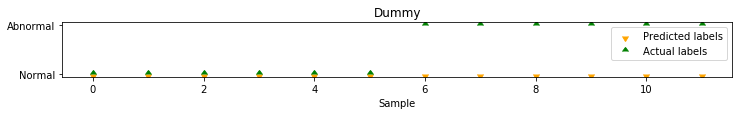

instance 27: ../data/2/WELL-00013_20170329020229.csv


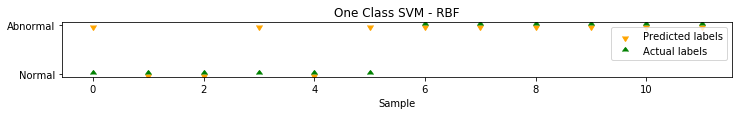

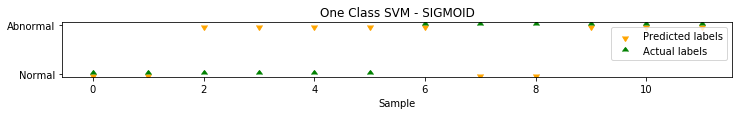

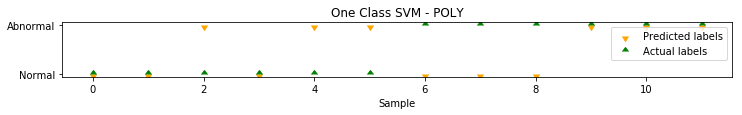

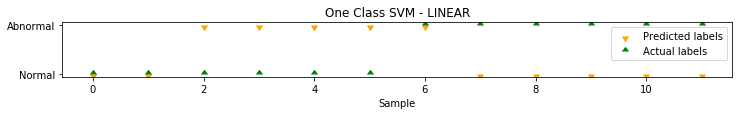

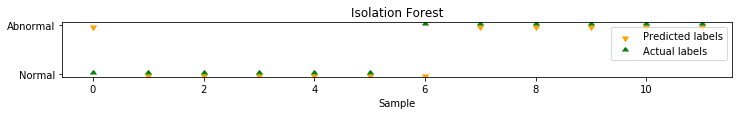

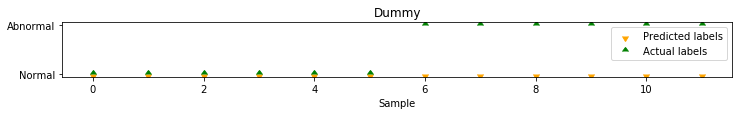

instance 28: ../data/5/WELL-00015_20170620160349.csv


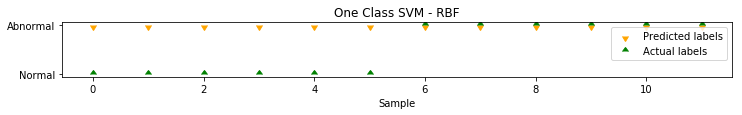

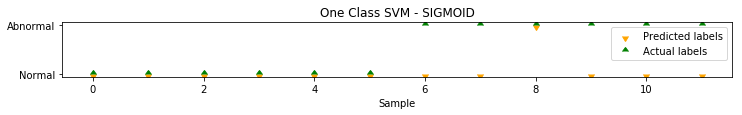

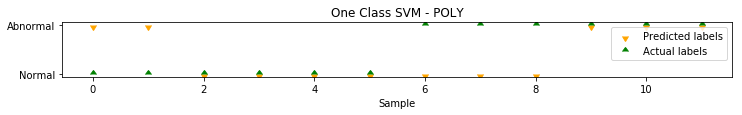

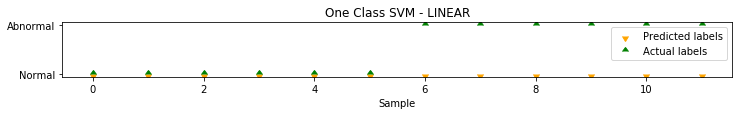

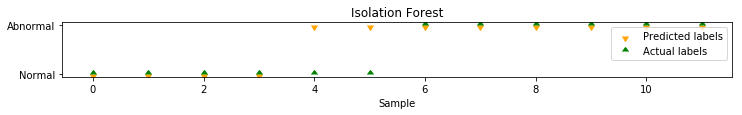

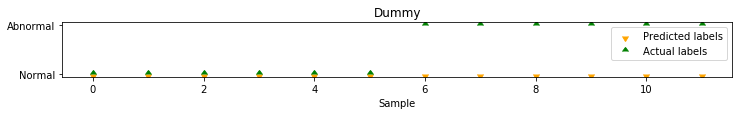

instance 29: ../data/5/WELL-00015_20171013140047.csv


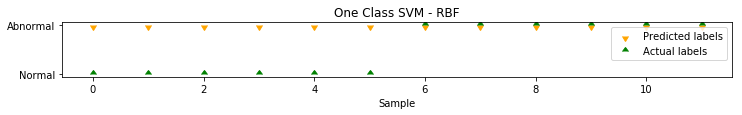

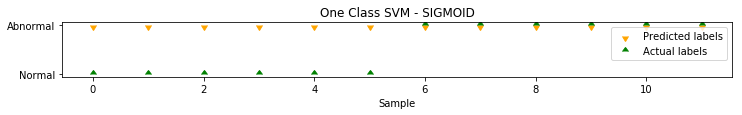

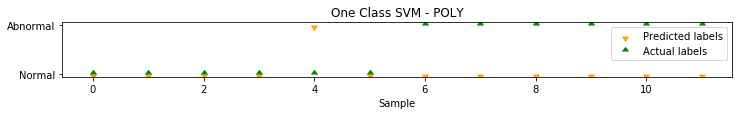

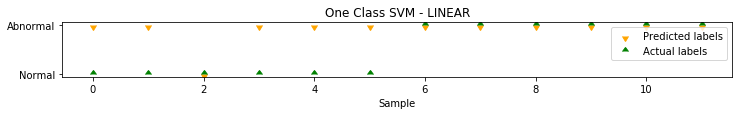

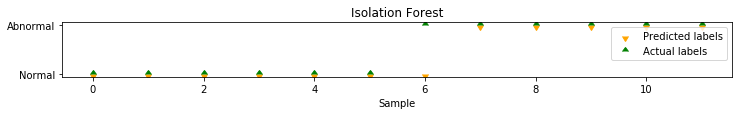

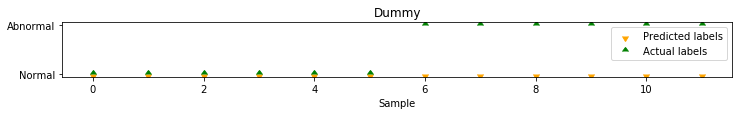

instance 30: ../data/5/WELL-00016_20180405020345.csv
	skipped because normal_period_size is insufficient for training (1145)
instance 31: ../data/5/WELL-00016_20180426142005.csv
	skipped because normal_period_size is insufficient for training (321)
instance 32: ../data/5/WELL-00016_20180426145108.csv
	skipped because normal_period_size is insufficient for training (376)
instance 33: ../data/5/WELL-00016_20180517222322.csv


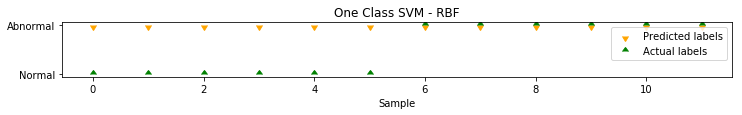

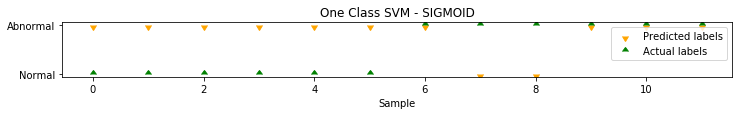

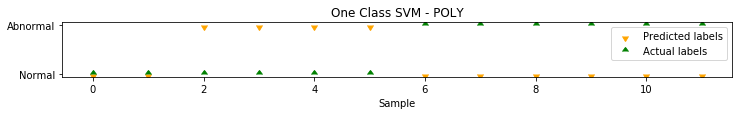

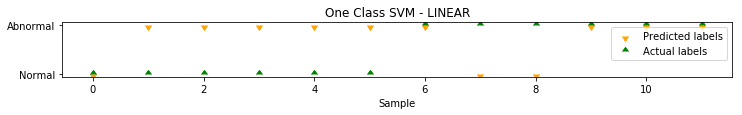

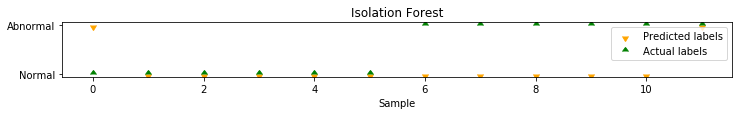

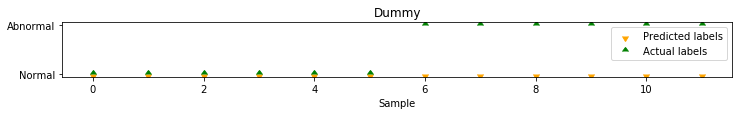

instance 34: ../data/5/WELL-00017_20140314180000.csv
	skipped because normal_period_size is insufficient for training (0)
instance 35: ../data/5/WELL-00017_20140317151743.csv


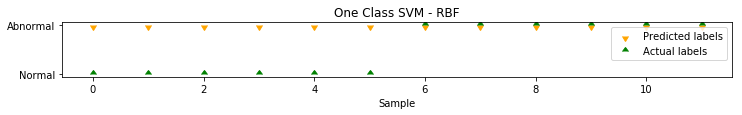

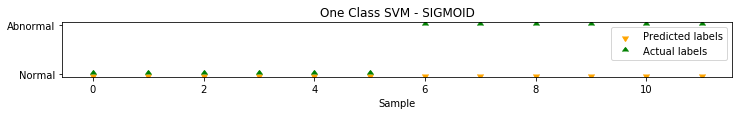

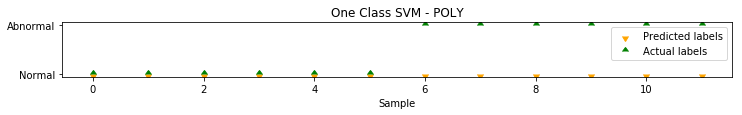

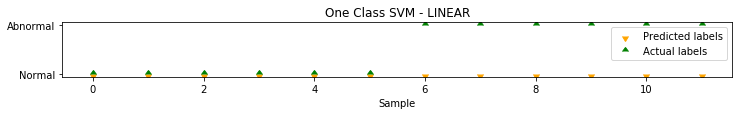

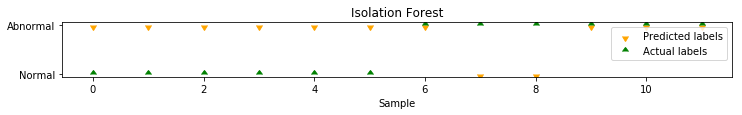

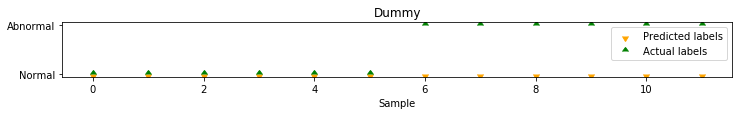

instance 36: ../data/5/WELL-00017_20140318023141.csv


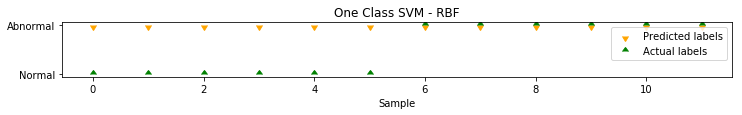

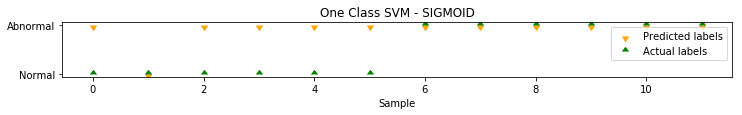

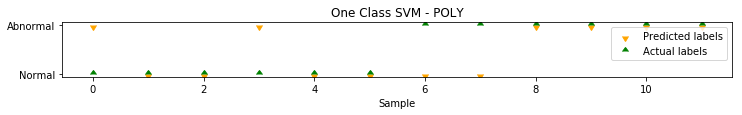

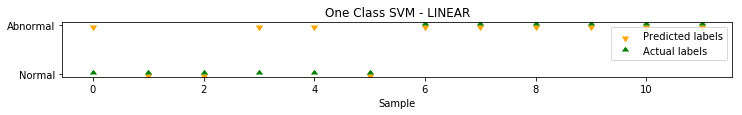

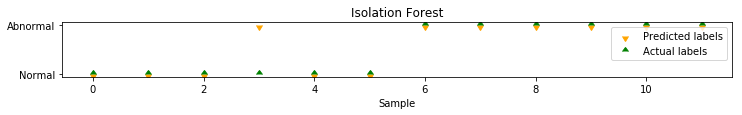

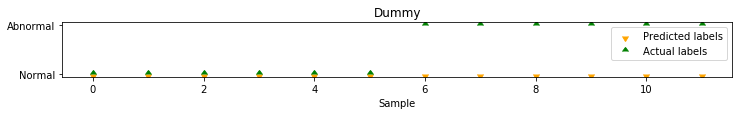

instance 37: ../data/5/WELL-00017_20140318160220.csv


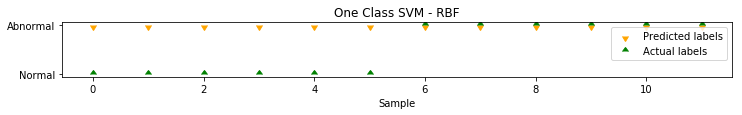

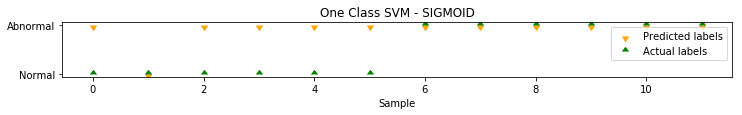

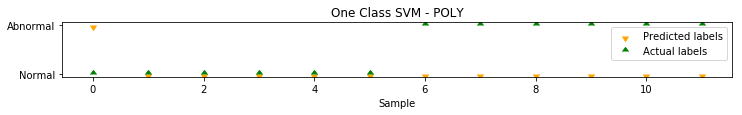

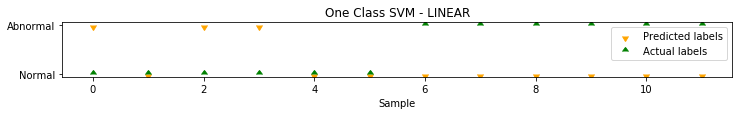

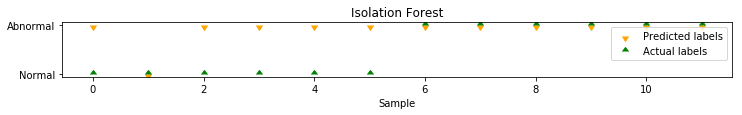

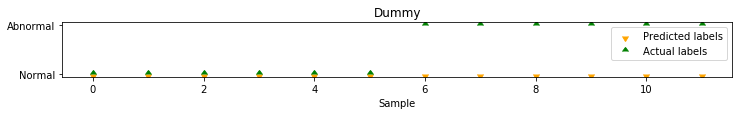

instance 38: ../data/5/WELL-00017_20140319040453.csv


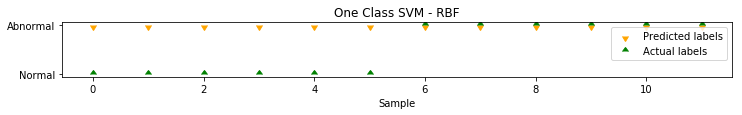

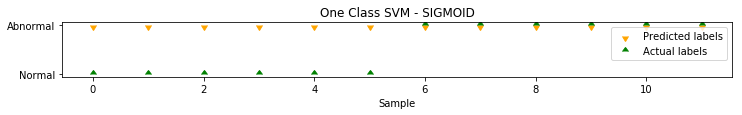

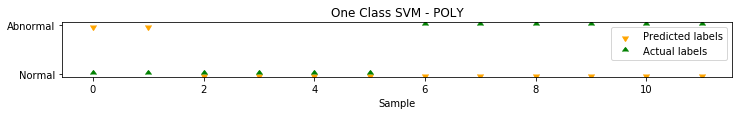

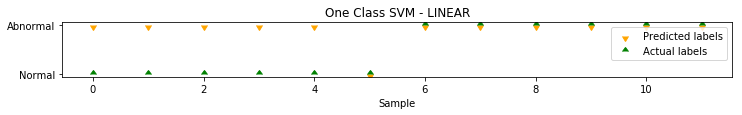

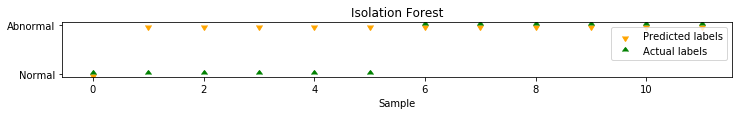

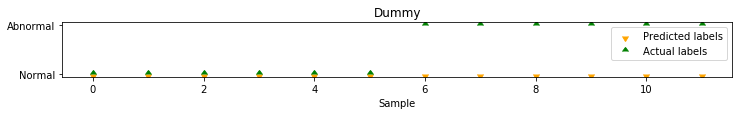

instance 39: ../data/5/WELL-00017_20140319141450.csv


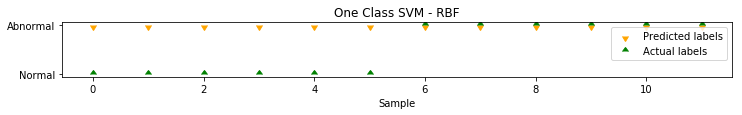

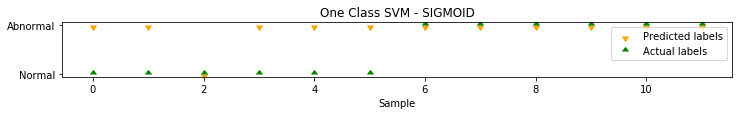

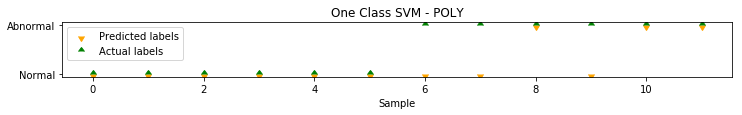

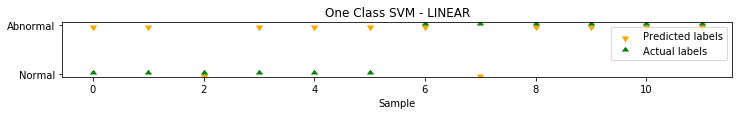

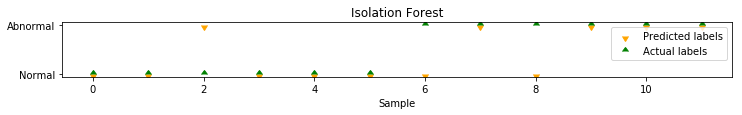

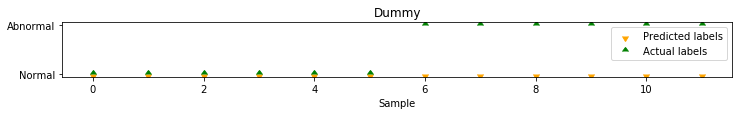

instance 40: ../data/6/WELL-00002_20140212170333.csv


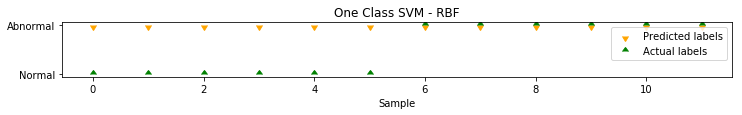

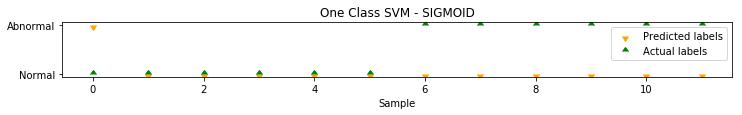

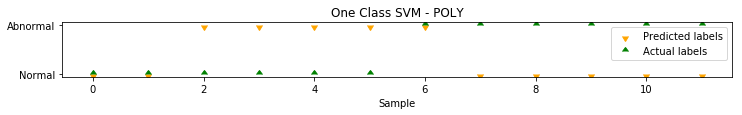

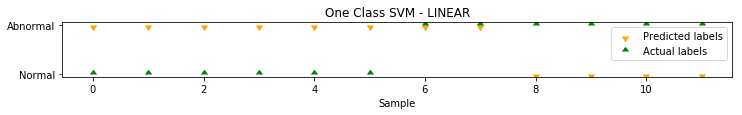

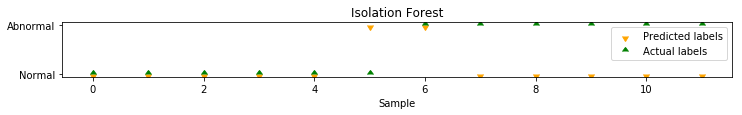

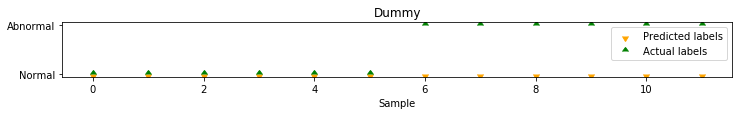

instance 41: ../data/6/WELL-00002_20140301151700.csv


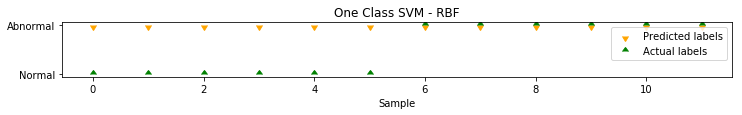

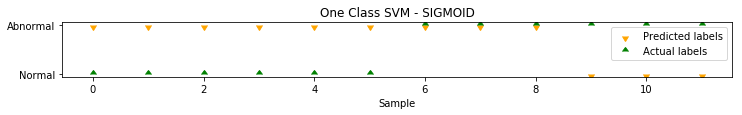

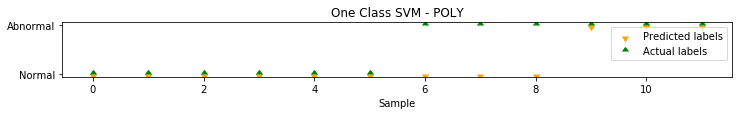

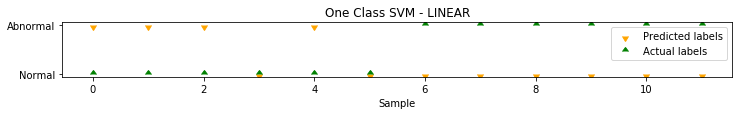

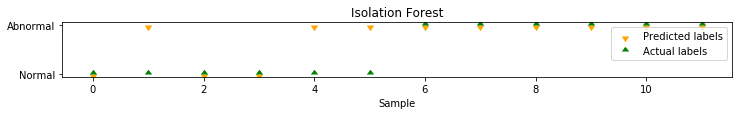

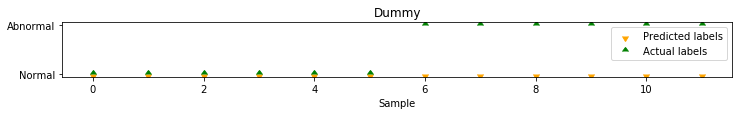

instance 42: ../data/6/WELL-00002_20140325170304.csv


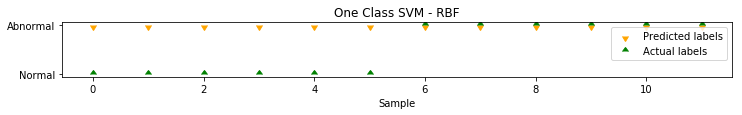

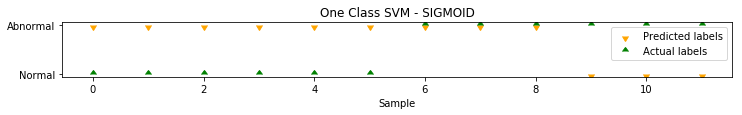

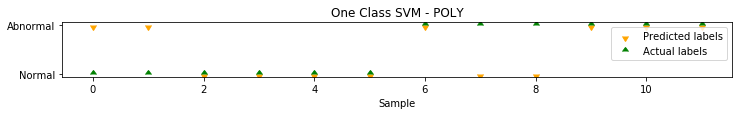

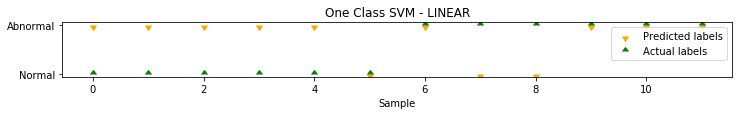

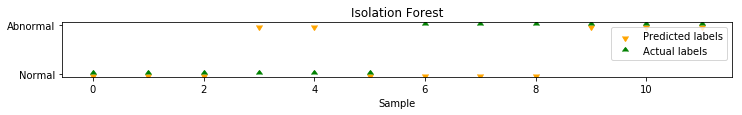

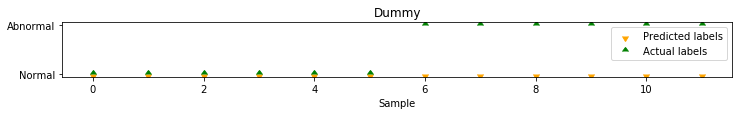

instance 43: ../data/6/WELL-00004_20171031181509.csv


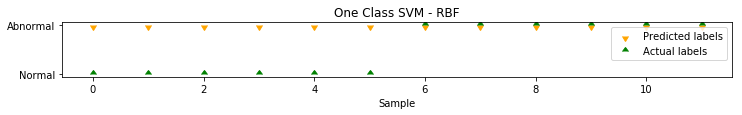

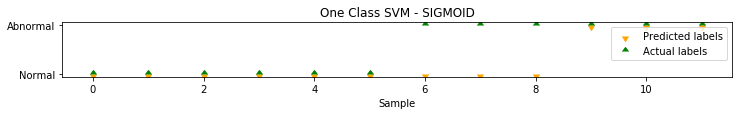

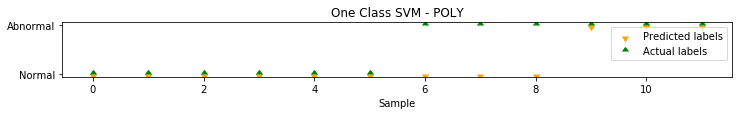

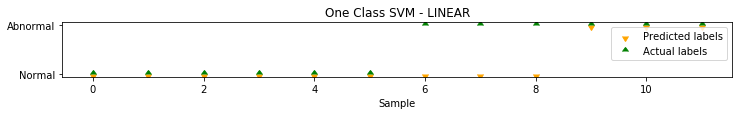

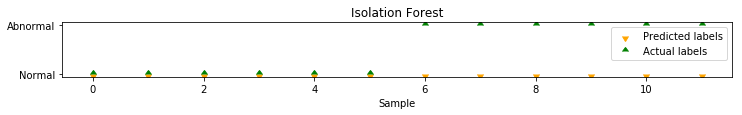

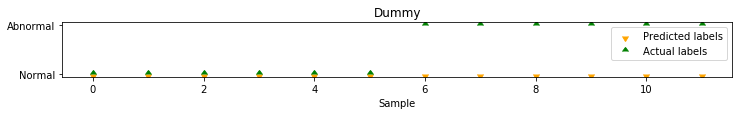

instance 44: ../data/6/WELL-00004_20171031193025.csv
	skipped because normal_period_size is insufficient for training (414)
instance 45: ../data/6/WELL-00004_20171031200059.csv
	skipped because normal_period_size is insufficient for training (845)
instance 46: ../data/7/WELL-00001_20170226220309.csv


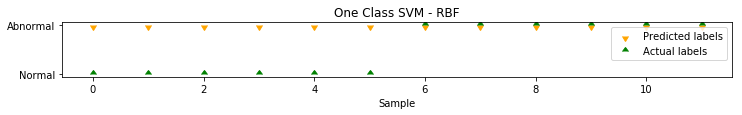

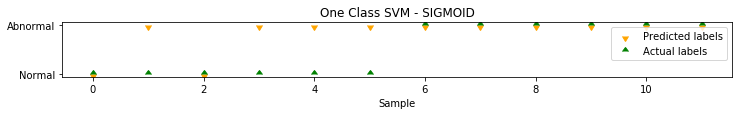

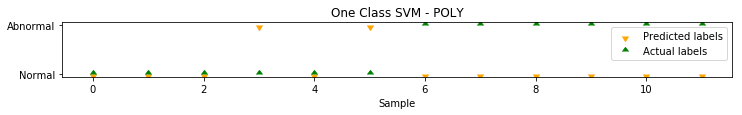

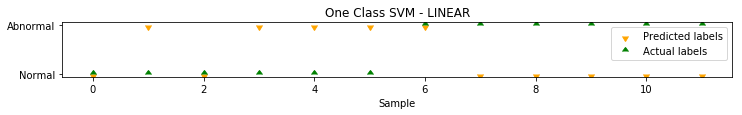

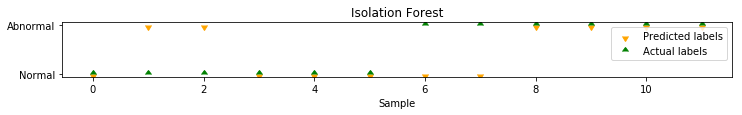

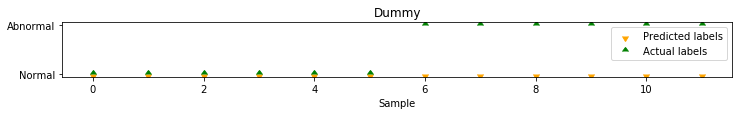

instance 47: ../data/7/WELL-00006_20180618110721.csv


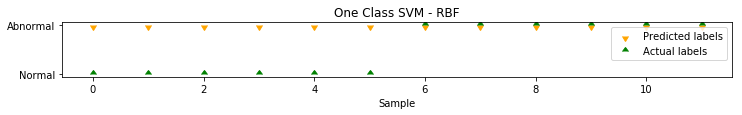

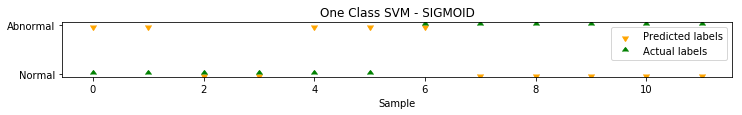

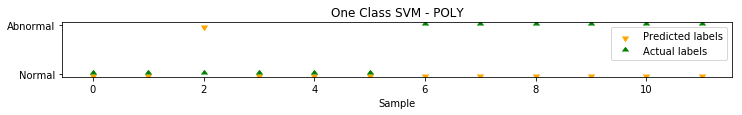

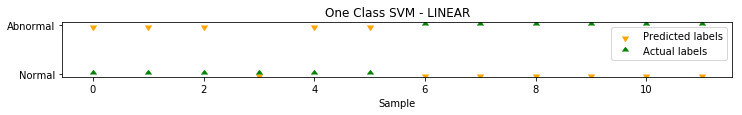

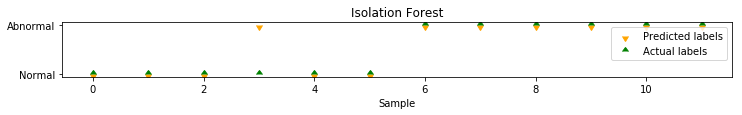

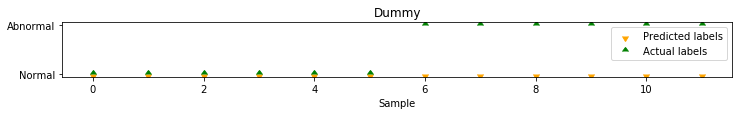

instance 48: ../data/7/WELL-00006_20180620181348.csv


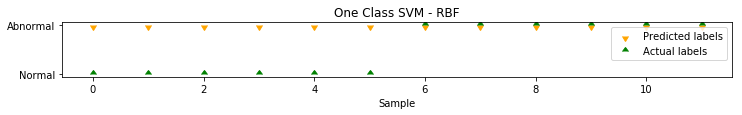

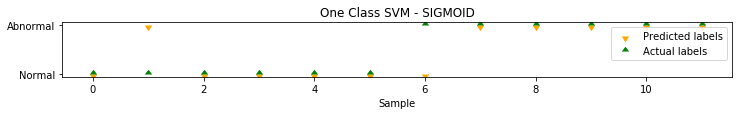

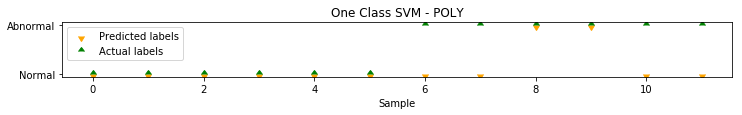

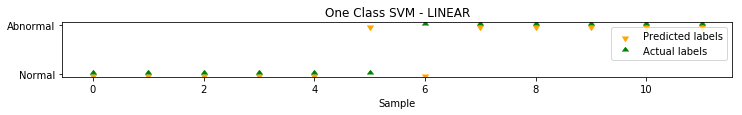

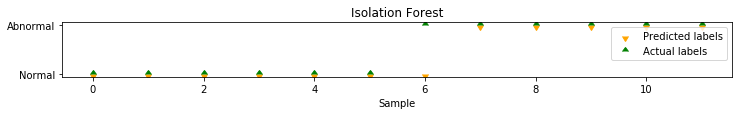

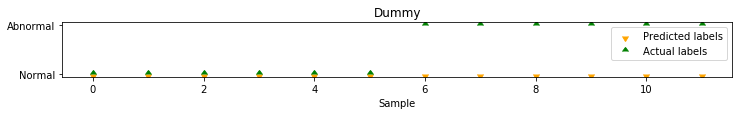

instance 49: ../data/7/WELL-00018_20180611040207.csv
	skipped because normal_period_size is insufficient for training (0)
instance 50: ../data/8/WELL-00019_20170301182317.csv


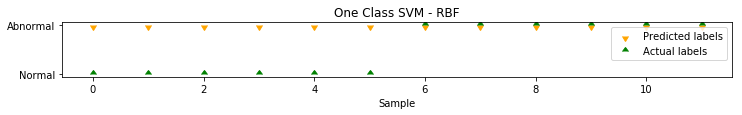

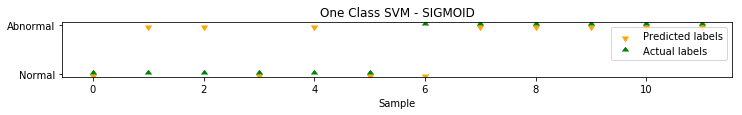

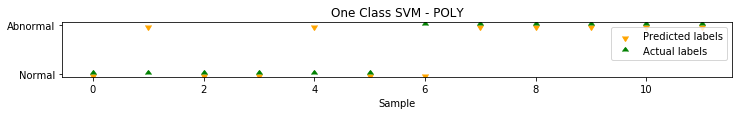

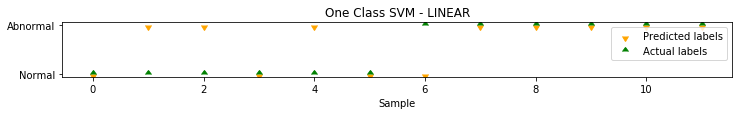

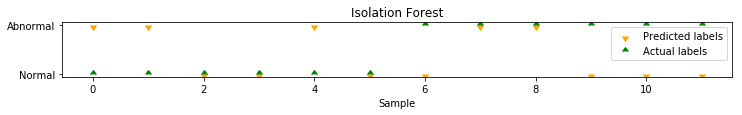

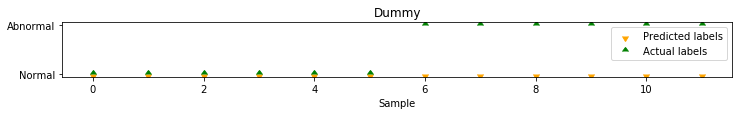

instance 51: ../data/8/WELL-00020_20120410192326.csv
	skipped because normal_period_size is insufficient for training (173)
instance 52: ../data/8/WELL-00021_20170509013517.csv


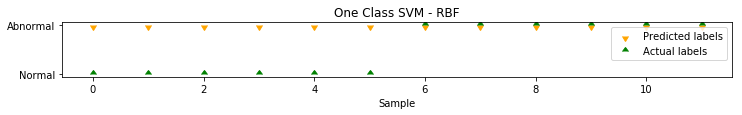

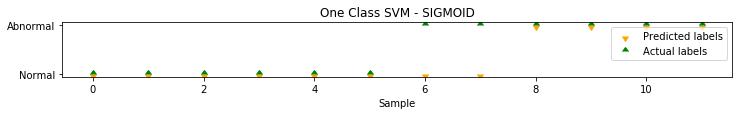

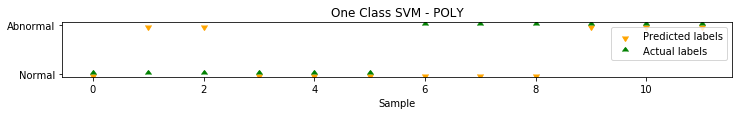

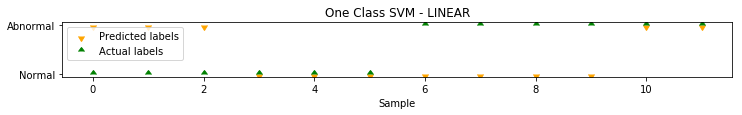

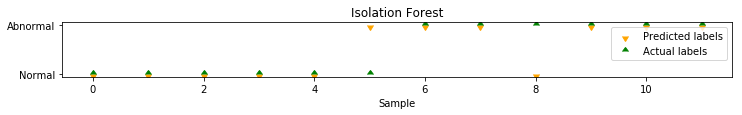

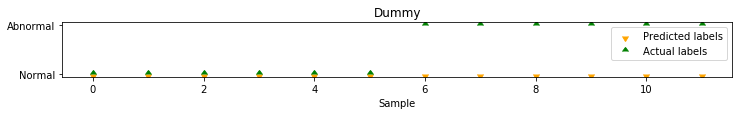

In [10]:
# For each real instance with any type of undesirable event
scores = pd.DataFrame()
ignored_instances = 0
used_instances = 0
for i, row in real_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    print('instance {}: {}'.format(i+1, instance_path))
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        print('\tskipped because normal_period_size is insufficient for training ({})'
              .format(normal_period_size))
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret

    # Changes types of the labels (tsfresh's requirement)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # We want binary classification: 1 for inliers (negative class = normal instance) and
    # -1 for outliers (positive class = instance with anomaly) (sklearn's requirement)
    y_test[y_test!=normal_class_code] = -1
    y_test[y_test==normal_class_code] = 1
    
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[good_vars] = scaler.fit_transform(df_samples_train[good_vars]).astype('float32')
    df_samples_test[good_vars] = scaler.transform(df_samples_test[good_vars]).astype('float32')
    
    # Extracts features from samples
    X_train = extract_features(df_samples_train, 
                               column_id='id', 
                               column_sort='timestamp', 
                               default_fc_parameters=df_fc_p,
                               impute_function=impute,
                               n_jobs=0,
                               disable_progressbar=disable_progressbar)
    X_train = X_train.reset_index(drop=True)
    X_test = extract_features(df_samples_test, 
                              column_id='id', 
                              column_sort='timestamp',
                              default_fc_parameters=df_fc_p,
                              impute_function=impute,
                              n_jobs=0,
                              disable_progressbar=disable_progressbar)
    X_test = X_test.reset_index(drop=True)
    
    # Trains, tests and calculates the scores
    scores = train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs)

# 3. Results

The results obtained with the implemented method are presented below.

In [11]:
print('number of used instances: {}'.format(used_instances))
print('number of ignored instances: {}'.format(ignored_instances))

number of used instances: 36
number of ignored instances: 16


In [12]:
print('used features: {}'.format(list(df_fc_p.keys())))

used features: ['median', 'mean', 'standard_deviation', 'variance', 'maximum', 'minimum']


The following commands conveniently permit saving and retrieving the results to/from a CSV file.

In [13]:
scores.to_csv(r'./demo_2_benchmark_anomaly_detection_scores.csv')
#scores = pd.read_csv(r'./demo_2_benchmark_anomaly_detection_scores.csv', index_col=0)

# 3.1. Metrics in Tabular Format

The following tables present the averages and standard deviation of the metrics, respectively. Both are ordered by F1 metric.

In [14]:
score_table = scores.groupby('CLASSIFIER').mean().sort_values(by=['F1'], ascending=False)
score_table

,F1,PRECISION,RECALL,TESTING[s],TRAINING[s]
CLASSIFIER,,,,,
Isolation Forest,0.726852,0.726852,0.726852,0.027317,0.085618
One Class SVM - RBF,0.532407,0.532407,0.532407,0.000440,0.000686
Dummy,0.500000,0.500000,0.500000,0.000057,0.000240
One Class SVM - POLY,0.472222,0.472222,0.472222,0.000485,0.000876
One Class SVM - SIGMOID,0.469907,0.469907,0.469907,0.000478,0.000855
One Class SVM - LINEAR,0.414352,0.414352,0.414352,0.000517,0.000879


In [15]:
scores.groupby('CLASSIFIER').std().sort_values(by=['F1'], ascending=True)

,F1,PRECISION,RECALL,TESTING[s],TRAINING[s]
CLASSIFIER,,,,,
Dummy,0.000000,0.000000,0.000000,0.000012,0.000077
One Class SVM - RBF,0.075271,0.075271,0.075271,0.000091,0.000111
Isolation Forest,0.182151,0.182151,0.182151,0.002064,0.005656
One Class SVM - POLY,0.187929,0.187929,0.187929,0.000146,0.000133
One Class SVM - LINEAR,0.194657,0.194657,0.194657,0.000150,0.000168
One Class SVM - SIGMOID,0.201338,0.201338,0.201338,0.000089,0.000128


# 3.2. Non-Parametric Multiple Comparison Analysis

The following output (p_value < 5%) reveals that the null-hypothesis that all classifiers have the same performance is false. That means that at least one of them have, with high probability, different F1 mean values compared to the others.

In [16]:
clfs_names = list(clfs.keys())
f1s = [scores.loc[scores['CLASSIFIER']==cn, 'F1'].values for cn in clfs_names]
f_value_stat, p_value, ranks, pivots = stac.friedman_test(*(f1s))
print('p_value: {}'.format(p_value))

p_value: 1.4454692998100427e-09


Now we investigate which classifiers have statistically different F1 mean values compared to the dummy classifier (always predicts the majority class = normal). The p_values and adj_p_values indicate that "Isolation Forest" is the only one that has a statistically better performance, with high probability, compared to the dummy classifier (< 5%).

In [17]:
ret = stac.holm_test(len(pivots), pivots, clfs_names, clfs_names.index('Dummy'))
comp, z_values_stat, p_values, adj_p_values = ret
for i in range(len(comp)):
    print('{}: \n\tp_values: {}\n\tadj_p_values: {}'.format(comp[i], p_values[i], adj_p_values[i])) 

Dummy vs Isolation Forest: 
	p_values: 3.215955563207196e-05
	adj_p_values: 0.00016079777816035978
Dummy vs One Class SVM - LINEAR: 
	p_values: 0.040627895878897036
	adj_p_values: 0.16251158351558814
Dummy vs One Class SVM - SIGMOID: 
	p_values: 0.5287333251214301
	adj_p_values: 1
Dummy vs One Class SVM - RBF: 
	p_values: 0.5495438817461777
	adj_p_values: 1
Dummy vs One Class SVM - POLY: 
	p_values: 0.5707503880581737
	adj_p_values: 1


# 3.3. Metrics in Boxplots

The boxplots presented below are ordered by F1 mean values of the considered classifiers.

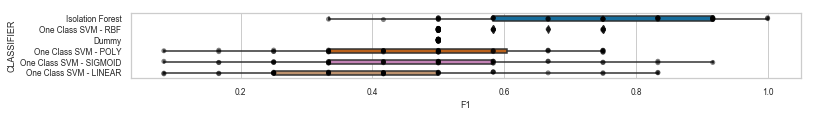

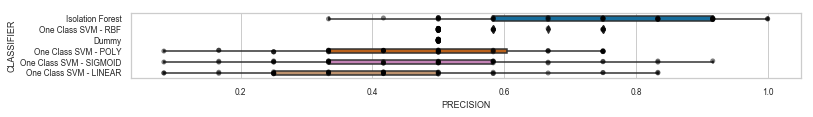

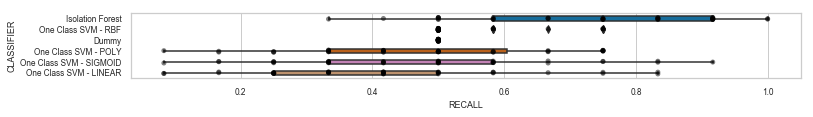

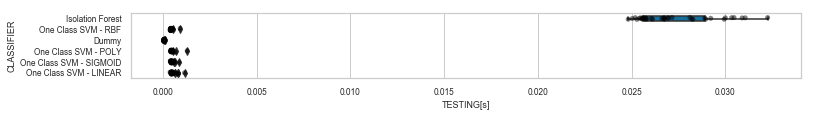

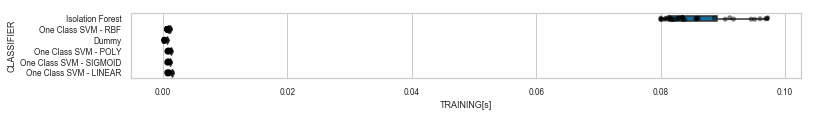

In [18]:
sns.set(font_scale=0.75, style="whitegrid")
for score in scores.columns.drop(['CLASSIFIER']):
    plt.figure(figsize=(12,1.2))
    bplot=sns.boxplot(y='CLASSIFIER', x=score, data=scores, width=0.4, 
                      palette='colorblind', order=list(score_table.index));
    bplot=sns.stripplot(y='CLASSIFIER', x=score, data=scores, jitter=True, marker='o', 
                        alpha=0.5, color='black', order=list(score_table.index))

# 4. Conclusion

Given the results presented above, we can state that the classifier "IsolationForest" presents better performance in terms of averages of the metrics F1, PRECISION and RECALL, but not in terms of the standard deviation of these metrics nor the times for training and testing. 

After a non-parametric multiple comparison analysis, we verified that the classifier "IsolationForest" produces statistically different F1 mean value compared to the dummy classifier.

Therefore, it is proved that machine learning algorithm can be used to detect anomalies in oil wells.